In [1]:
# if using colab run this
!git clone https://github.com/HAVIGILI/Anomaly_understanding.git
%cd Anomaly_understanding

Cloning into 'Anomaly_understanding'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 77 (delta 19), reused 19 (delta 9), pack-reused 45 (from 2)
Receiving objects: 100% (77/77), 162.33 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/Anomaly_understanding


In [2]:
%pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 882.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 51.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlin

In [3]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
validation_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=train_transform, download=True)
validation_dataset = datasets.CIFAR10(root="./data", train=False, transform=validation_transform, download=True)
ood_dataset1 = datasets.SVHN(root="data", split="test", transform=validation_transform, download=True)
ood_loader1 = DataLoader(ood_dataset1, batch_size=32, shuffle=False)
print("length of train data", len(train_dataset), "length of validation data", len(validation_dataset), "nr of classes", len(train_dataset.classes))

cifar_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
cifar_validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
length of train data 50000 length of validation data 10000 nr of classes 10


In [9]:
from pytorch_ood.model import WideResNet
import torch
import numpy as np
import matplotlib.pyplot as plt

num_classes = 10
model = WideResNet(num_classes=10, pretrained="cifar10-pt").to(device).eval()
import torch

def compute_average_features(model, data_loader, num_classes, device, weighted=False):
    """
    Compute the average feature vector and covariance matrix per class from a dataset.

    Parameters:
        model (torch.nn.Module): The model to use.
        data_loader (DataLoader): DataLoader for the dataset.
        num_classes (int): Number of classes.
        device (torch.device): The device to run the inference on.
        weighted (bool): If True, multiply each feature vector element-wise
                         by the classifier weight corresponding to its true label.
                         (Assumes the classifier weights are in model.fc.weight.)

    Returns:
        dict: A dictionary mapping each class index to its average feature tensor.
        dict: A dictionary mapping each class index to its covariance matrix.
    """
    model.eval()

    if weighted:
        classifier_weights = model.fc.weight  # shape: [num_classes, feature_dim]

    # Initialize accumulators for each class
    feature_sums = {i: None for i in range(num_classes)}
    counts = {i: 0 for i in range(num_classes)}
    feature_vectors = {i: [] for i in range(num_classes)}  # Store individual features

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Run a forward pass
            _ = model(images)
            features = model.features(images)  # shape: [batch_size, feature_dim]

            # Process each sample in the batch
            for i in range(images.size(0)):
                label = labels[i].item()
                feat = features[i]
                if weighted:
                    weight_vector = classifier_weights[label].to(device)
                    feat = feat * weight_vector

                # Accumulate features
                if feature_sums[label] is None:
                    feature_sums[label] = feat.clone()
                else:
                    feature_sums[label] += feat

                # Store individual feature vectors for covariance calculation
                feature_vectors[label].append(feat.cpu().numpy())

                counts[label] += 1

    # Compute the average feature vector and covariance matrix per class
    average_features = {}
    covariance_matrices = {}

    for label in range(num_classes):
        if counts[label] > 0:
            avg_feat = feature_sums[label] / counts[label]
            average_features[label] = avg_feat

            # Compute covariance matrix
            feature_matrix = torch.tensor(feature_vectors[label])  # Shape: [N, feature_dim]
            centered_features = feature_matrix - avg_feat.cpu()  # Subtract mean
            covariance_matrix = torch.mm(centered_features.T, centered_features) / (counts[label] - 1)  # (N-1) normalization
            covariance_matrices[label] = covariance_matrix
        else:
            average_features[label] = None
            covariance_matrices[label] = None

    return average_features, covariance_matrices


def get_sorted_indices(vector, plot=False):
    # Dictionary to store the sorted indices for each class
    sorted_indices_dict = {}

    for cls, feat in vector.items():
        # Convert the tensor to a NumPy array
        feat_np = feat.cpu().numpy()

        # argsort returns the indices that would sort the array in ascending order,
        # so the highest values end up on the right.
        sorted_indices = np.argsort(feat_np)
        sorted_values = feat_np[sorted_indices]

        # Save the sorted indices for later use
        sorted_indices_dict[cls] = sorted_indices

        if plot:
            # Plot the sorted feature vector
            plt.figure()
            plt.plot(range(len(sorted_values)), sorted_values, marker='o', linestyle='-')
            plt.title(f"Sorted Average Vector for Class {cls}")
            plt.xlabel("Sorted Feature Index")
            plt.ylabel("Feature Value")
            plt.grid(True)
            plt.show()

        # Optionally print the original indices for the sorted order
        print(f"Class {cls} sorted indices (original positions): {sorted_indices}")
    return sorted_indices_dict

def plot_sorted_feature_for_sample(sample_index, dataset, model, sorted_indices_dict, device, weighted=False):
    """
    Runs inference on a single sample from the provided dataset, optionally multiplies the feature vector
    by the classifier weight corresponding to the predicted class, sorts the resulting feature vector using
    precomputed sorted indices, and plots the sorted feature vector.

    Parameters:
        sample_index (int): Index of the sample in the dataset.
        dataset (torchvision.datasets): The dataset (e.g., CIFAR10 test or SVHN) from which to fetch the sample.
        model (torch.nn.Module): The model that provides both forward() and features() methods.
        sorted_indices_dict (dict): A dictionary mapping each class (int) to its sorted indices (numpy array),
                                    computed from training data.
        device (torch.device): The device to perform inference on.
        weighted (bool): Whether to multiply the feature vector by the classifier weight for the predicted class.
                         Defaults to False.
    """
    # Retrieve the sample.
    image, true_label = dataset[sample_index]

    # Prepare the image (add batch dimension and move to device).
    image = image.unsqueeze(0).to(device)

    # Run inference to get logits and features.
    model.eval()
    with torch.no_grad():
        logits = model(image)              # Get logits.
        features = model.features(image)   # Get the flattened feature vector.

    # Determine the predicted class.
    predicted_class = logits.argmax(dim=1).item()
    print(f"Predicted class: {predicted_class}, True label: {true_label}")

    # Squeeze the batch dimension from the features.
    feature_vector = features.squeeze(0)

    # If weighted, multiply the feature vector element-wise by the classifier weight vector.
    if weighted:
        classifier_weights = model.fc.weight  # Assumes shape: [num_classes, feature_dim]
        weight_vector = classifier_weights[predicted_class].to(device)
        feature_vector = feature_vector * weight_vector

    # Retrieve the sorted indices for the predicted class.
    sorted_indices = sorted_indices_dict[predicted_class]

    # Sort the feature vector using the sorted indices.
    sorted_feature_vector = feature_vector[sorted_indices].detach().cpu().numpy()

    # Plot the sorted feature vector.
    plt.figure()
    plt.plot(range(len(sorted_feature_vector)), sorted_feature_vector, marker='o', linestyle='-')
    mode = "Weighted" if weighted else "Unweighted"
    plt.title(f"{mode} Sorted Feature Vector (Predicted Class {predicted_class})")
    plt.xlabel("Sorted Feature Index")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.show()

    return sorted_feature_vector

    import torch

def compute_mahalanobis_distances(model, data_loader, average_features, covariance_matrices, device, weighted=False):
    """
    Compute the Mahalanobis distance for each image relative to its predicted class distribution.

    Instead of using the provided label, the function uses the predicted class from the model's logits.
    If weighted is True, each feature vector is multiplied element-wise by the classifier weight corresponding
    to its predicted class (assumes model.fc.weight exists).

    Parameters:
        model (torch.nn.Module): The model used for both feature extraction and prediction.
        data_loader (DataLoader): DataLoader for the dataset.
        average_features (dict): A dictionary mapping each class index to its average feature tensor.
        covariance_matrices (dict): A dictionary mapping each class index to its covariance matrix tensor.
        device (torch.device): The device to run computations on.
        weighted (bool): If True, element-wise multiply each feature vector by the classifier weight of its
                         predicted class.

    Returns:
        list: A list of tuples (image_index, predicted_class, mahalanobis_distance) for each image.
              If the average feature or covariance for the predicted class is missing, the distance is set to None.
    """
    model.eval()
    distances = []

    if weighted:
        classifier_weights = model.fc.weight  # shape: [num_classes, feature_dim]

    image_index = 0
    with torch.no_grad():
        for images, _ in data_loader:  # ignore dataset labels since they may not match the original ones
            images = images.to(device)

            # Obtain logits to determine the predicted class.
            logits = model(images)  # Expected shape: [batch_size, num_classes]

            # Extract features.
            features = model.features(images)  # Expected shape: [batch_size, feature_dim]

            for i in range(images.size(0)):
                # Get predicted class from the highest logit.
                predicted_class = torch.argmax(logits[i]).item()
                feat = features[i]

                # If weighted, multiply by the classifier weight of the predicted class.
                if weighted:
                    weight_vector = classifier_weights[predicted_class].to(device)
                    feat = feat * weight_vector

                # Retrieve the average feature and covariance matrix for the predicted class.
                avg_feat = average_features.get(predicted_class, None)
                cov_matrix = covariance_matrices.get(predicted_class, None)

                if avg_feat is None or cov_matrix is None:
                    distance = None
                else:
                    # Move to the correct device and compute the pseudo-inverse for numerical stability.
                    avg_feat = avg_feat.to(device)
                    cov_matrix = cov_matrix.to(device)
                    inv_cov = torch.pinverse(cov_matrix)

                    # Compute Mahalanobis distance: sqrt((x - μ)^T @ inv_cov @ (x - μ))
                    delta = feat - avg_feat
                    distance = torch.sqrt(torch.matmul(delta.unsqueeze(0),
                                                       torch.matmul(inv_cov, delta.unsqueeze(1)))).item()

                distances.append((image_index, predicted_class, distance))
                image_index += 1

    return distances

def plot_mahalanobis_histograms(id_distances, ood_distances, bins=50):
    """
    Plot histograms of the Mahalanobis distances for both in-distribution (ID) and out-of-distribution (OOD) datasets.

    Parameters:
        id_results (list): List of tuples (image_index, predicted_class, distance) for the ID dataset.
        ood_results (list): List of tuples (image_index, predicted_class, distance) for the OOD dataset.
        bins (int): Number of bins for the histograms.
    """
    plt.figure(figsize=(12, 6))

    # Plot overlapping histograms
    plt.hist(id_distances, bins=bins, alpha=0.5, label='In-Distribution', color='blue')
    plt.hist(ood_distances, bins=bins, alpha=0.5, label='Out-of-Distribution', color='red')

    plt.xlabel("Mahalanobis Distance")
    plt.ylabel("Frequency")
    plt.title("Histogram of Mahalanobis Distances (ID vs OOD)")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()


Class 0 average feature shape: torch.Size([128])
Class 1 average feature shape: torch.Size([128])
Class 2 average feature shape: torch.Size([128])
Class 3 average feature shape: torch.Size([128])
Class 4 average feature shape: torch.Size([128])
Class 5 average feature shape: torch.Size([128])
Class 6 average feature shape: torch.Size([128])
Class 7 average feature shape: torch.Size([128])
Class 8 average feature shape: torch.Size([128])
Class 9 average feature shape: torch.Size([128])


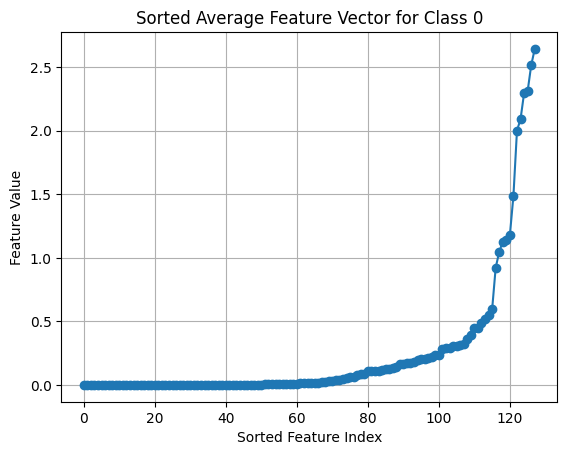

Class 0 sorted indices (original positions): [  2 121  87 100  97  21  99  16 109  79  81  42  12  82  58   1  24  94
  84 116  10 115  23  63  47  54 114  25  22 119 125  72  60  51  44  86
 126  74  48  95   9  69  50 117 112  83  75 104  49   8  89  20 111 103
 113 118   4  11  27  66  61  52  38  85  73 102 107  41  45  98  36 108
  39 120  92  91  93 110  70   0 123  34  43  96  26  65  67  14  29 105
  77  64  33  13  31  30  56  78  62  46  76  55  35  37   6  57  71   7
  53  90 127  59  40  32   5  28 101  17 124  80  19 122  18   3 106  88
  15  68]


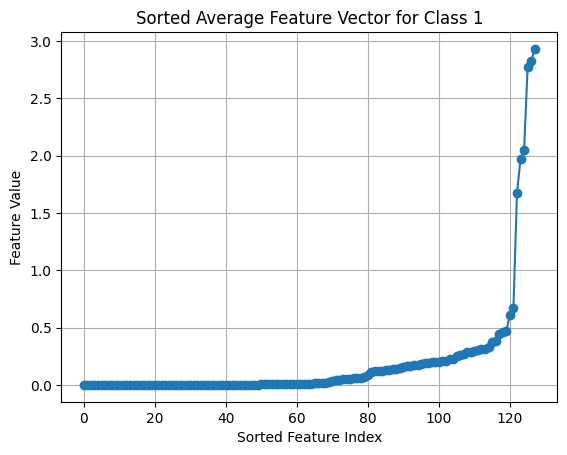

Class 1 sorted indices (original positions): [121  21  87  99   2 100  97  16 109  82  54  79   1  58  63 115  47  12
  94 116  10  81  84 114  24  25 119 104  42  74  48  23  72 125   9   8
 126  83  95  75  49  60 112  22  20  50  51 117  86 111 113 107  69   4
  44 118 103  85  89  11  27  66  41 102  45 120  98  92  61  38  91 123
  39  73  14   0  52  76 108  77  36  32 122  93  28 127   3  17  90  53
 124  40  70 101  78  96 106  68  29   5  26  13  18 105  43  19  80   7
  34   6  33  64  65  37  71  56  46 110  31  57  59  15  67  55  62  88
  35  30]


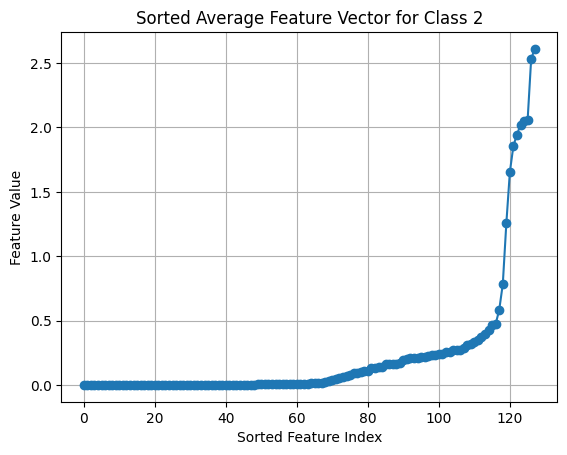

Class 2 sorted indices (original positions): [121   2  21  87 100  97  99  16 109  79  12  82  81  23  54  94  42  24
  58  48   1  47 116  84 115  72  25 104  63  51 119  83  10  95 114 125
  49  22   9 126 112  60  69   8  75  50  11 118  74 117  86   4  44 113
 111  20 107  66  45  61 103  98  27  52  85  89  41  38 102 108  73  91
  90  76  32  77 120  93  92 110  36  26 124  80 123 127  14   0  28  29
  88  96  18  17   3  56  78  31  34   5  53  67  30 105  71  35  64  39
  70  62  59  68  19  37   7  57  55 122  43  65 106 101  13  40  46  15
   6  33]


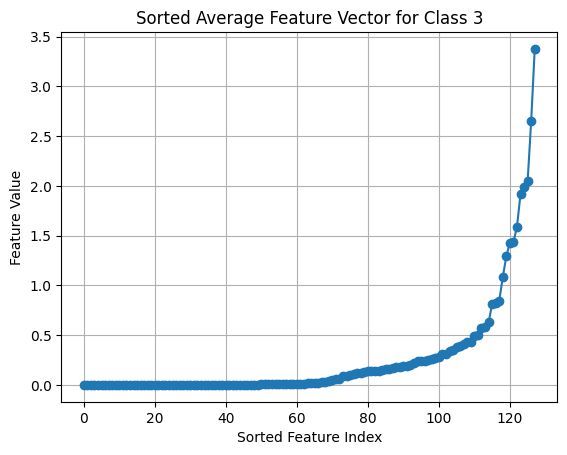

Class 3 sorted indices (original positions): [  2 121  87  21 109  99  16 100  97  94  42  79  81  84   1  12  47  54
  82  58  23  10 115  48  25 104  49  24 116  51 119  75 114  44 125  60
  74  83  95  72  63  11   9 126 117   8  22 112 111  69  86  50 118 103
 113  20  89  98   4  27  66  85  41 102  52 107  61  38  45 108  73 123
  77  91 120  76  14  28  29  92 127  55  32  90  17  39  43  68  13  18
  65  78 110  26  56  93  46  36 106  62  34  30  96  35  70  15 101 122
  67   3 105   0  80   6   7  88  57  31  40 124  19   5  71  53  37  64
  33  59]


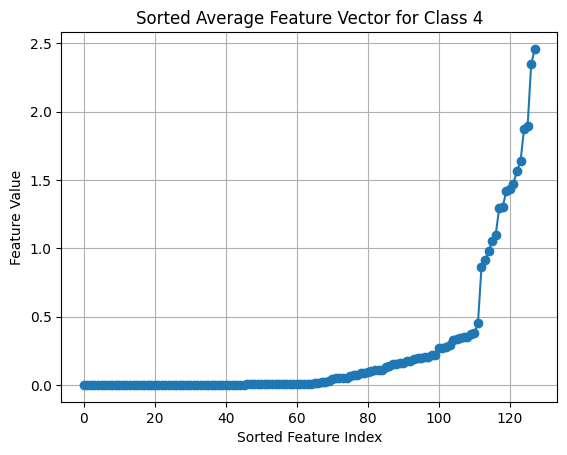

Class 4 sorted indices (original positions): [121   2  87  97  16  21 109  99  79 100  81   1  94  54  42  47  58  12
  82  84  25  49 116 115 125  48  83  10  63  60  95 114  24  72  44 119
  23 104 117 126  51  86   9 112 118  69  74 111 103  75  22  50 113  20
   8  45  85  66  11   4 107  61  89  27 102  98  38  41 108 120  91  39
 123  76 110  52  73 122  14  36   5 124  67  90  92  93  77  88  43  55
  30  15  53   3  35 105  71 101   6  46 106  32  37  65  59  57  62  31
   7   0 127  68  28  70  34  18  26  80  29  40  33  17  19  96  78  64
  13  56]


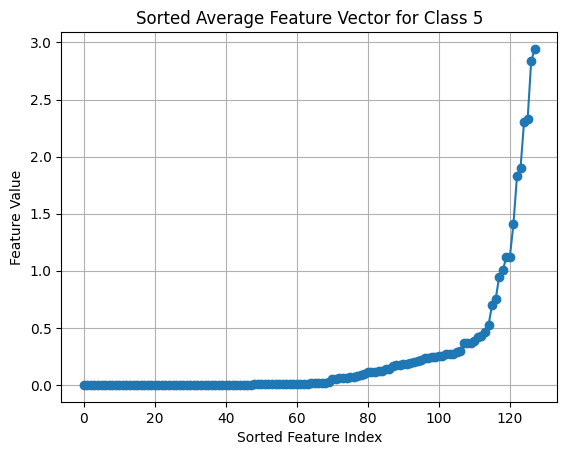

Class 5 sorted indices (original positions): [  2  87 121  21 100  16  99  97  79  81  82  94 109  58  23  12  84  48
  54 115  42  72  10 116  49  47  51   1 114  25  24  63  60 104  83 125
 119  74 126  95  75   9  69   8  22 117  50  86 111 112  44  11 103 113
  85  20  52 102 118   4  89  27  98  41  61  66 107  38 120  45  77 108
 123  36  73  32  76 127 110  28  90   0  39  93  17  14  91 122  96 106
  92  62  78  29  40  18 101  46  71  67  37  88  64  30   7  55  13 124
  19   5  15  33   3  53  68  70 105  35  65  34  26  56  43  80  57   6
  31  59]


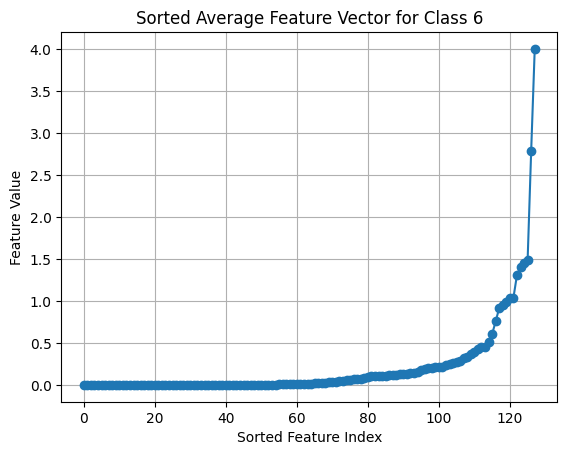

Class 6 sorted indices (original positions): [121  87  21   2 100  99  97  16 109  42  94  58  81  12  82  79 116   1
  47  84  54  72  10 125  24 114  49  23 115 104  83  95  25  51 119  75
  22  63  74 117   9  60 112 111  48   8 126 118  86  50 103 113  11  69
  20   4  44  66 102  41  45  85  89  38  61  27 107 108  91 120  36  52
  76  98  77  73  90  93  70 127  67 124 101  92   0  80  14 106  39  68
  34  53  19  32  26 123  65   6  31  35  33  29  15  59  56   3  88  55
  78  17 110  43   7  18  30  13   5  37 122 105  62  28  71  40  96  64
  46  57]


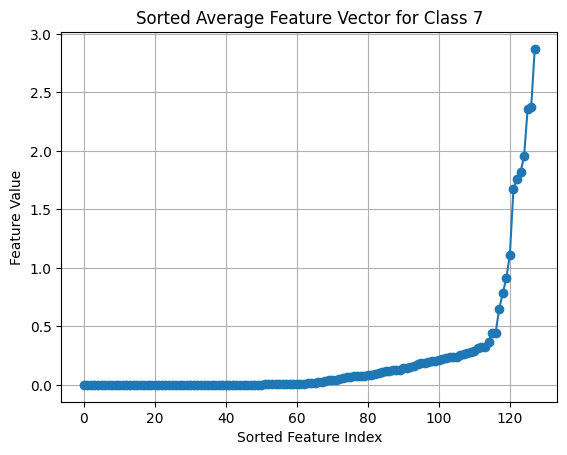

Class 7 sorted indices (original positions): [  2 121  21  87 100  16  99  79  81  97 109  42  12  82  47  84  72  54
 116  58  94   1 115  23  10  24  44 104 114 125  51  63  60  83  48 117
  49  22   8 112 126   9 119  69  75  95  25  86 118  50  74  11 113 103
  20  85   4 111  89  61  45 107  27  41 102  66  38  98  73  92  52  76
 108  91  93  36  90  39 127 120  32 110  28  34  43  96  64  80 123 105
  19  26  71  40  17  88  35  57   0  77   5  78 124  67  30 101  14  62
  59 122   3  15 106  68  13   7  70  33   6  46  29  65  55  53  56  31
  18  37]


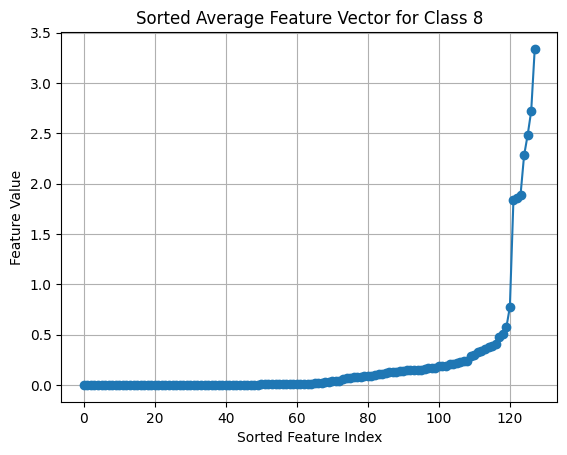

Class 8 sorted indices (original positions): [ 21 121  87   2 100  99  23  16  97 109  81  42  47  79  82  94  58 116
  63   1  12  84  72 115  10  24  54  25  49  51 125  22 114  95  83  74
  60 104   8   9  48 119 111  50 117  44  69  86  20 118 126  75 103  27
 107  61  11 112 113  89  45  41   4 102  85  98  66  52 108 120  38  91
  73 123  90  36  39 122  67  70 127 110  92  76   5  17  28  34  15  19
  55  40  35  77  80  14  62   3  26  96  13 124  18   0  53  29  32  64
  43  57  56  37   6  59  46  65  71  93  31  33 106  78 101  88  30  68
 105   7]


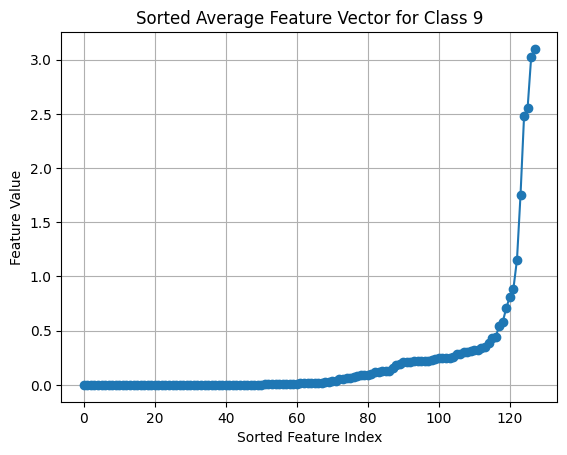

Class 9 sorted indices (original positions): [121   2  21  87 100  16  99 109  97  79  81  82  47  54  94  23 125  58
  72  84   1  10  12  42 116 114 119  49 115   8  24  25  22  51  95  69
  63 126  48  74  60   9 117 104  75  83 112  20 118  50  86 113 107 103
  44 111  27  89  11  41  85   4  66  38 102  73  45  61  98  92  52  39
 110  93  32  36  76 120 127  91  90   5 108  70  28 105  71  55 123  88
  34  96  19  77  80  15 124  30 106 101  46 122  31  64  26  29  18  40
  17  65  57  59  56   6  37  78  33  14  13  43   0  68  67  53   3  35
  62   7]


In [11]:
average_features_unweighted, unweighted_covariance_matrices = compute_average_features(model, cifar_train_loader, num_classes, device, weighted=False)
average_features_weighted, weighted_covariance_matrices = compute_average_features(model, cifar_train_loader, num_classes, device, weighted=True)

In [ ]:
sorted_indices_dict_unweighted = get_sorted_indices(average_features_unweighted, True)
sorted_indices_dict_weighted = get_sorted_indices(average_features_weighted, True)

sample_index = 0
plot_sorted_feature_for_sample(sample_index, validation_dataset, model, sorted_indices_dict_unweighted, device, weighted=False)

sample_index = 0
plot_sorted_feature_for_sample(sample_index, ood_dataset1, model, sorted_indices_dict_unweighted, device, weighted=False)

sample_index = 0
plot_sorted_feature_for_sample(sample_index, validation_dataset, model, sorted_indices_dict_weighted, device, weighted=True)

sample_index = 0
plot_sorted_feature_for_sample(sample_index, ood_dataset1, model, sorted_indices_dict_weighted, device, weighted=True)

In [ ]:
id_distances = compute_mahalanobis_distances(model, cifar_validation_loader, average_features, covariance_matrices, device, weighted=False):
ood_distances = compute_mahalanobis_distances(model, ood_loader1, average_features, covariance_matrices, device, weighted=False):
plot_mahalanobis_histograms(id_distances, ood_distances, bins=100):

id_distances = compute_mahalanobis_distances(model, cifar_validation_loader, average_features, covariance_matrices, device, weighted=True):
ood_distances = compute_mahalanobis_distances(model, ood_loader1, average_features, covariance_matrices, device, weighted=True):
plot_mahalanobis_histograms(id_distances, ood_distances, bins=100):

Predicted class: 3, True label: 3


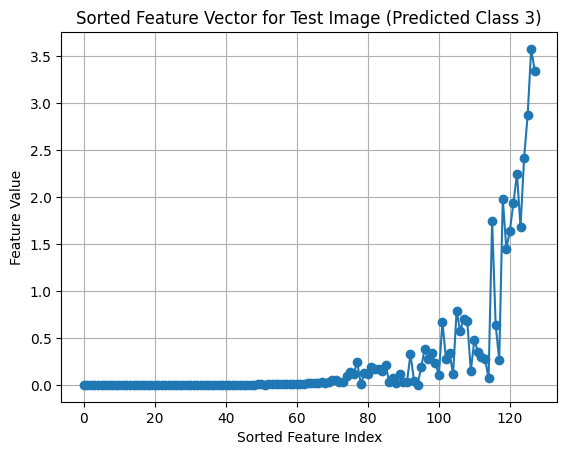

100%|██████████| 64.3M/64.3M [00:39<00:00, 1.63MB/s]


Predicted class for OOD image: 3


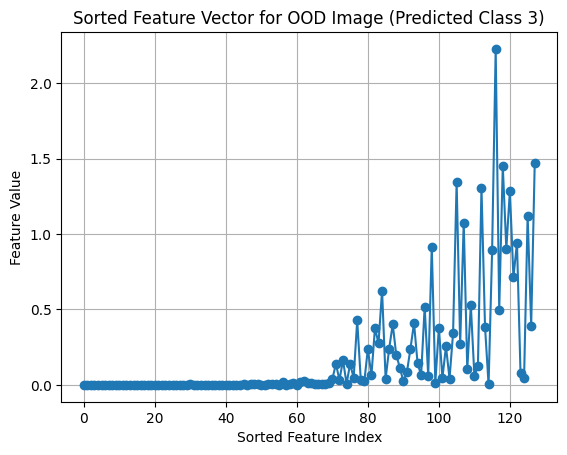

Class 0 average weighted feature shape: torch.Size([128])
Class 1 average weighted feature shape: torch.Size([128])
Class 2 average weighted feature shape: torch.Size([128])
Class 3 average weighted feature shape: torch.Size([128])
Class 4 average weighted feature shape: torch.Size([128])
Class 5 average weighted feature shape: torch.Size([128])
Class 6 average weighted feature shape: torch.Size([128])
Class 7 average weighted feature shape: torch.Size([128])
Class 8 average weighted feature shape: torch.Size([128])
Class 9 average weighted feature shape: torch.Size([128])


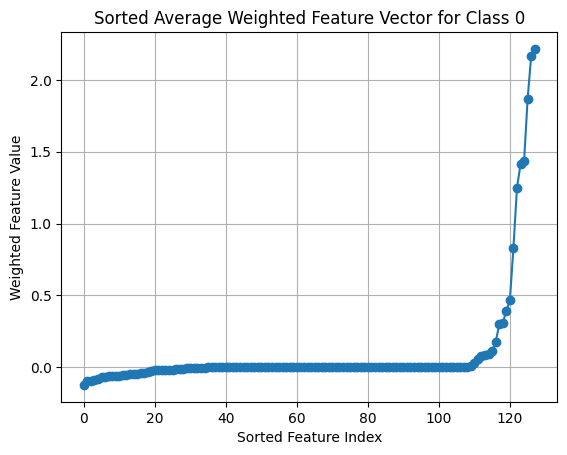

Class 0 sorted indices (original positions): [ 33   7  37  57  30  59  46  31  56   6  13  64  62  35  78 105  53  65
  55  71  96  67  29  43  34  40  26  70   0 110  93  14  92  36  39 108
  73  52  38  66  61 107  89  91   4 103  27 111  20 113  86  50 117  69
 126  85  44  22 102  48  24 112 119  23  63  94  82  42 114  58  12  79
  74  10   1  97  21 100  81 121  99   2  87  16 109  47  84 115 116  72
 125  54  25  51  60  75  83   9  95 104  49   8 118  11  41  45  98 120
 123  77  76   5  90 127  28  32 101  80  17  19 124 122  18   3  88 106
  15  68]


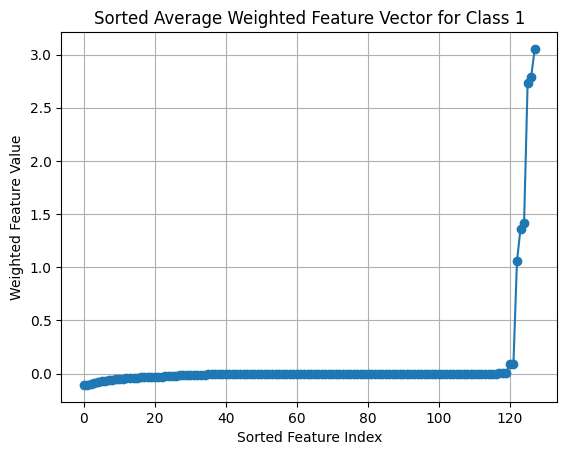

Class 1 sorted indices (original positions): [ 59   7  57  31  33  37  68   6  64   3 105  56  53  40 101  13  80  19
  78 106  71  46  18   5  96  65 122 124  70  26  17  43  29  28   0  14
  34  93  77  76  32 123 127  39  91  73  92 120  45  66  41 107  85   4
 113 111  89  20 102 103 118  50  27  75   9 126  22 112  83  74 104 119
   8  63  10 114 115   1  12 116  54  25  82  97  58  99  16 121  21  87
   2 109 100  79  24  94  47  81  23  84  95  42 125 117  49  48  51  72
  60  86  44  38  69  11  98  61  52 108  36  90  15 110  67  62  55  88
  35  30]


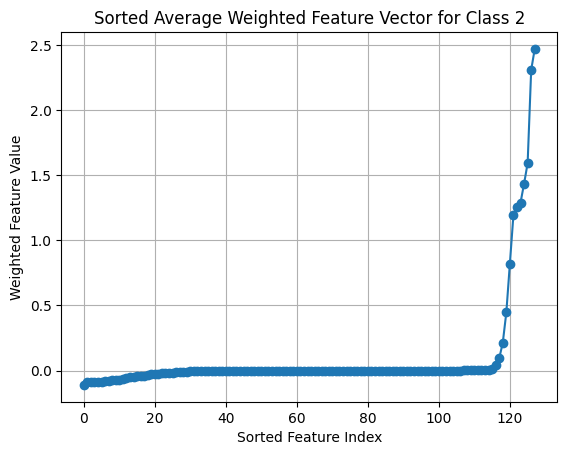

Class 2 sorted indices (original positions): [  7  18  88  59  57  37  31  64  62  53  56  35  68  80  30   3  78 105
  71 124  96  29  67  26  17   5  19  28   0  55  32  90  77 110  93  34
  91 108  76  98  52  61  45  66 107   4 112  50  69   8  11  22  83 126
 119  75  27  48 104 118  25  49  24  84  95  51  82  54 116  23  12 109
  42  99  97  16 100 121  58   2  87  81  21  79  94  72   9  47 115   1
  63  10 114 125 117  74  38  60  86  20  44 113 111 103  85  41  89 102
  73  14  92 120  36 123 127  70  39 122  43  65 106  46 101  13  40  15
  33   6]


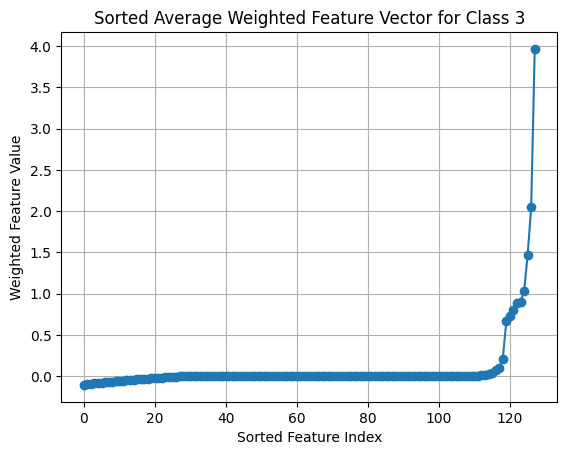

Class 3 sorted indices (original positions): [ 46  68  56  18  13   7  62  65  35 106  43   6  15  30  55  78 101  57
  29  17   3  26  28  34  14 123  77  67 127 105  52 108  98  66  11 111
   9  44  75  60 104  49  48  25  84   1  23  94 109  42  99  87  21   2
  47 121 100  81  79  24  12  16 115  10  51 117  54 125  97  74  58   8
 119 116  82  69  63 114  83  95  72 126  86  22 112 103 118  89  50 113
  41  20  85   4  27  61 107 102  96  32  38  45 120  76  73  91  92  90
  39 110 122  70  88  80  93  36   0  31  40 124  19   5  37  71  53  64
  33  59]


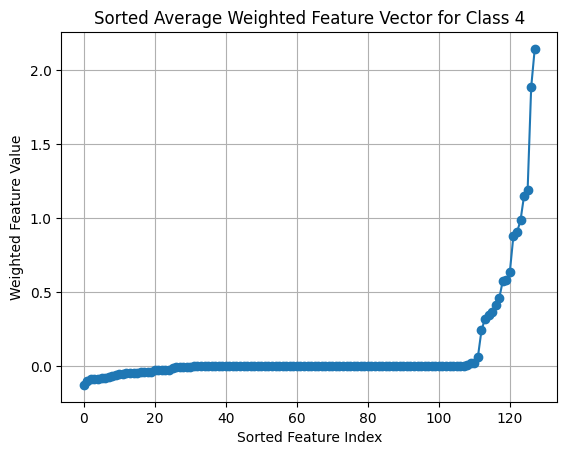

Class 4 sorted indices (original positions): [  7   6  46  59  37  57  31  62  53  15  35  88 101   3 106  68  30  71
  65 105  55   5  43 122 124  67  14 110  39 123  93 120  76  91 108  38
 102  98  45  61  27  85 107  66 103   4 113  89 118 111  50  86 112 117
  44  20  69  60  95  48  83 126  63  25  49   1  72 125 116  42 115  94
  79  81  97 109  16 100  58   2 121  87  21  99  23  47 114  54  84  10
 119  12  82  24 104   9  51  74  75  22  11   8  41  36  73  92  90  52
  77   0  32 127  28  70  18  34  40  26  33  80  29  17  19  96  64  78
  13  56]


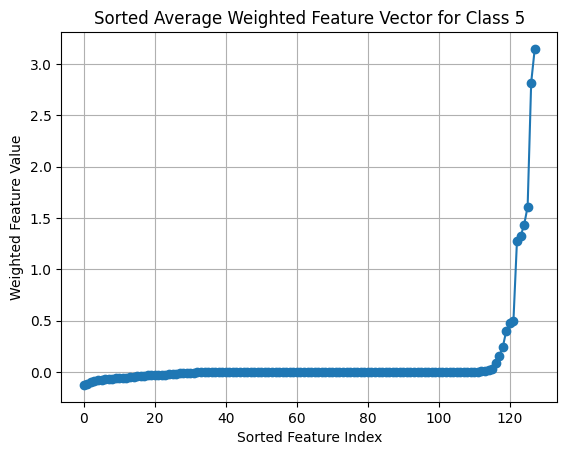

Class 5 sorted indices (original positions): [ 33  37  88   7  40  68  46  18  15  64  62 106  13  71  30 101  19  78
 122  17  55   3  96  53  67  29  28   0 127  32  77 110  36  90 123  76
 120  14  98  52  41 102  85  38  61  11  86 126  74   9   8  72  49  48
  60 115  84 119  75  69  51  25  82  63  83  94  58 114  79  10  97  81
  16  54  12 109  87   2 121 100  21 125  99  23  47 116  42  95 104   1
  24  22 112  50 117 111 113   4  44 118 103  20  27  66  89 107  45 108
  93  73  39 124   5  91  92  35 105  70  65  56  26  34  57  43  80   6
  31  59]


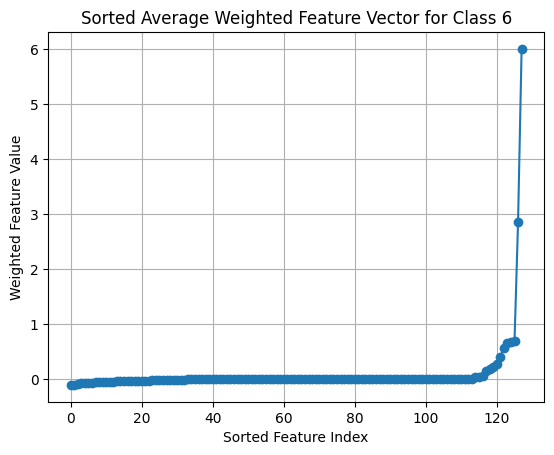

Class 6 sorted indices (original positions): [ 33  59  56   6  31  88  35   7  19  68  53  65  18  15  80  55 101 106
  29  78 124   3  34  26  70  67   0 127  30  77  14  93  36  90  76  91
  52 108 120  38  41  45 102  66  11 111 113 103   4  75  74   9 112  22
  49 104  60 125 114 117 116  10  72  83  58  12  42  94  47  24 121  21
  87   2 100  95  81  99  16  20 109  97  54   1  79 115  25  82 119  84
  51  23  63   8 118  50  48 126  86  44  69  85  89  73  61  27 107  98
  32  92  39  17 123  43  13  62 110  37   5 105 122  28  40  71  96  64
  46  57]


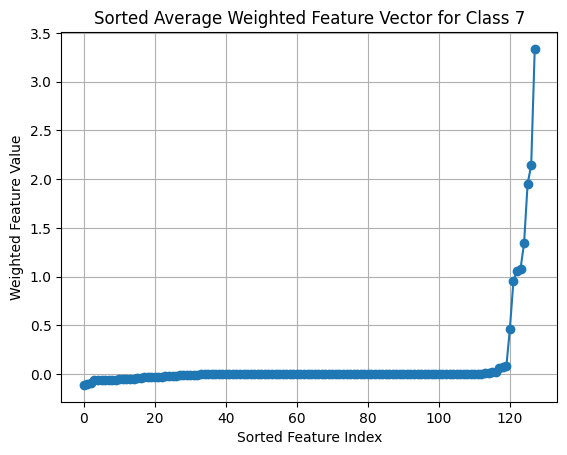

Class 7 sorted indices (original positions): [ 59   7  57  68  40  35  15 106  88  62   3  64  30  19 101  80  13  78
  67 105  43  71  96  34  17   5  28 122  26 127  32 124  90  93 110  92
  39  76  91  36  73  45  61 102  89  41  85  27   4  11 107   8 118 103
  86  69 112  50 117  60  44 126 104  24  72 115  47  84  42 116  82  81
  79  16 100  99   2 121  21  87  12  97 109   9  75  51  54  48   1  23
  94  10  58 125 114  83  63  22  95  49 113 119  25  74  20 111  38  98
 108   0  66  52 120 123  77  14  33  70   6  46  29  55  65  53  56  31
  18  37]


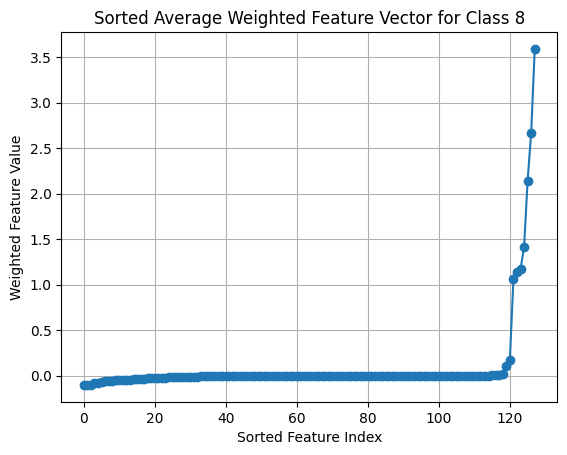

Class 8 sorted indices (original positions): [ 31  59  57   6  33  15  56   3  35  13  18  40  53  62  64  37  19  80
  55  43  46 122  65   5  17  26  96  67  34 124  70  28  29  90 127 123
  14 110  39  92  91  73 108   0  36  52  61  41  45 107  27  98 102  89
  20 118 111  86  44 103   9  22   8  95  83  51  49  25 104 114  63  24
 125  74  72  82 116  47   1  10  42  81  12  23  54 115 100  87  21 109
   2 121  97  99  58  16  84  79  94  60  48 119  11 113  69  50 126 117
  75 112   4 120  85  66  38  76  71  77  32  93 106 101  78  88  30  68
 105   7]


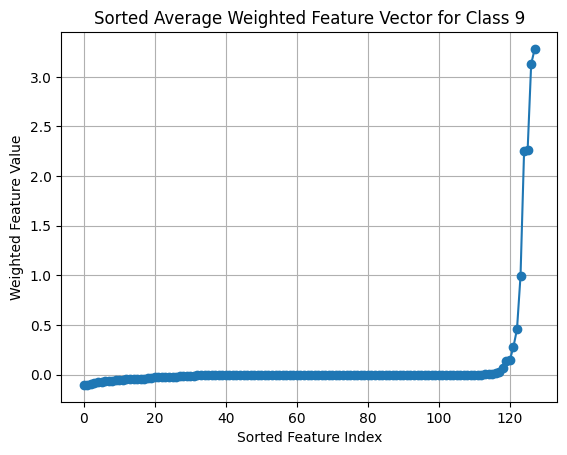

Class 9 sorted indices (original positions): [ 88  59  33  57  31  56  30   6  15  40  18 101  37  46  19  64 106  80
  55 105  71  65  26  96  13   5  34  29  70  28 122  17 124 127  32  78
  93 110  76  39  92  73  36  90  52  38 102 107  27  41  89  20 113 118
  44 112  85   8  69  95  75 117  22  74 119 114 125  50  72  47  10  84
  51  54  82  23  49  94  99  81  21 100  16 109  79  87   2 121  97  58
   1  42  25 116  63  12  48 115  60  24 126  66 104 103  83   9  86  11
 111   4  45  61  98 120  91 108 123  77  43  14  68   0  67  53  35   3
   7  62]


Predicted class: 3, True label: 3


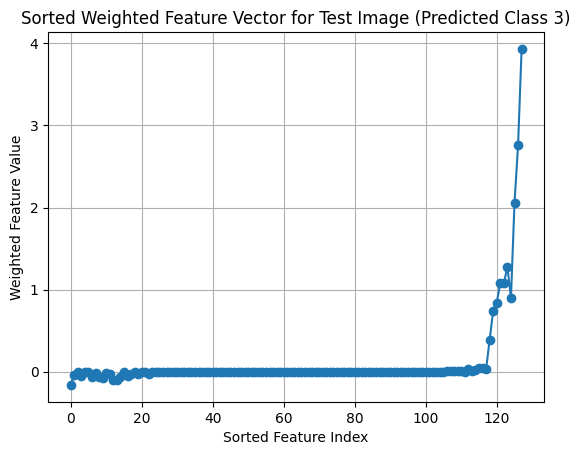

Predicted class for OOD image: 0


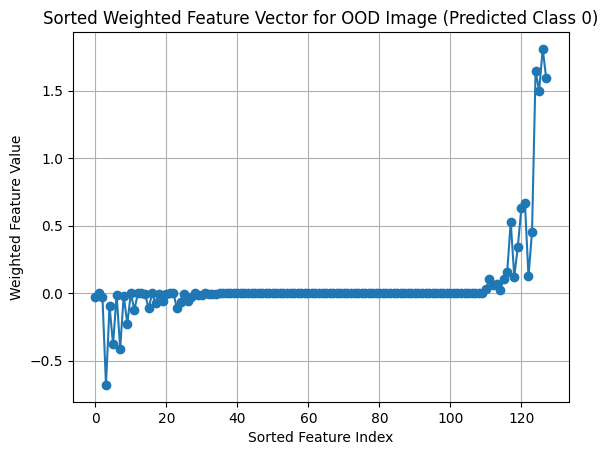

In [ ]:
#import torchvision
#from custommodel import CustomModel

#cnn_model = CustomModel(32, len(train_dataset.classes))

In [ ]:
#from trainer import Trainer

#ModelTrainer = Trainer(cnn_model, cifar_train_loader, cifar_validation_loader, 10, 0.001)
#ModelTrainer.train()

In [ ]:
from pytorch_ood.model import WideResNet
from torchvision import datasets
from pytorch_ood.utils import ToUnknown
import random
from torch.utils.data import Subset

trans = WideResNet.transform_for("cifar10-pt")

class ToTensorTarget:
    def __call__(self, y):
        return torch.tensor(y)

import torchvision.transforms as T

target_transform = T.Compose([
    ToUnknown(),
    ToTensorTarget()
])

ood_dataset1 = datasets.SVHN(root="data", split="test", transform=trans, download=True, target_transform=ToUnknown())
ood_dataset2 = datasets.FakeData(size=10000, image_size=(3, 32, 32), num_classes=10, transform=trans, target_transform=target_transform)
ood_dataset3 = datasets.MNIST(root="data", train=False, transform=trans, download=True, target_transform=ToUnknown())
ood_dataset4 = datasets.CIFAR100(root="data", train=False, transform=trans, download=True, target_transform=ToUnknown())
ood_dataset5 = datasets.FashionMNIST(root="data", train=False, transform=trans, download=True, target_transform=ToUnknown())
ood_dataset6 = datasets.STL10(root="data", split="test", transform=trans, download=True, target_transform=ToUnknown())

id_dataset = datasets.CIFAR10(root="./data", train=False, transform=validation_transform, download=True)

ood_datasets = [ood_dataset1, ood_dataset2, ood_dataset3, ood_dataset4, ood_dataset5, ood_dataset6]  # Add all your OOD datasets here

desired_size = 5000  # Set your desired size

for i, ood_dataset in enumerate(ood_datasets):
    all_indices = list(range(len(ood_dataset)))
    random.shuffle(all_indices)
    subset_indices = all_indices[:desired_size]
    subset = Subset(ood_dataset, subset_indices)
    ood_datasets[i] = subset

In [ ]:
from anomaly_detector import AnomalyDetector

model = WideResNet(num_classes=10, pretrained="cifar10-pt").to(device).eval()
calibration_dataset = train_dataset
id_test_dataset = id_dataset

for i, ood_dataset in enumerate(ood_datasets):
    print("OOD dataset", i)
    ood_test_dataset = ood_dataset
    detector = AnomalyDetector(model, calibration_dataset, id_test_dataset, ood_test_dataset, device=device)

    layers = [model.conv1, model.block1, model.block2, model.block3, nn.Sequential(model.bn1, model.relu)]
    head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), model.fc)

    print("multimahalanobis distance results:")
    detector.multimahalanobis(layers, True)

    print("mahalanobis distance results:")
    detector.mahalanobis(True)

    # print("openmax results:")
    # detector.openmax(True)

    # print("gram results:")
    # detector.gram(head, layers, 10, [1, 2, 3, 4, 5], True)

    # print("maxsoftmax results:")
    # detector.maxsoftmax(True)

    # print("mcd results:")
    # detector.mcd(30, True)

In [ ]:
import requests

# URL of the plane image
url = "https://th.bing.com/th/id/R.21621d8860f8aa6040a48c551a930de2?rik=3uoSLAbD6Voriw&riu=http%3a%2f%2fjamsdesignsinc.com%2fwp-content%2fuploads%2f2018%2f06%2fAirplane_01-square-1024x1024.jpg&ehk=n5hvZiqC3bgBZZ3z9tNUuH%2fBdsLAQFf%2bb2atiLN4Vx0%3d&risl=&pid=ImgRaw&r=0"

# Download the image
response = requests.get(url)
if response.status_code == 200:
    with open("plane.jpg", "wb") as f:
        f.write(response.content)
    print("Image downloaded: plane.jpg")
else:
    print("Failed to download image")

from PIL import Image
from torchvision import transforms

# Load the downloaded image
img = Image.open("plane.jpg")

# Define CIFAR-10 preprocessing: resize, convert to tensor, and normalize
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 pixels
    transforms.ToTensor(),       # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (CIFAR-10 stats)
])

# Preprocess the image
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
print("Preprocessed image tensor:", input_tensor.shape)

# Load your trained model
cnn_model.eval()  # Ensure the model is in evaluation mode

# Pass the image through the model
with torch.no_grad():
    output = cnn_model(input_tensor.to(device))
    predicted_class = output.argmax(dim=1).item()

# CIFAR-10 class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print the prediction
print("Predicted class:", class_labels[predicted_class])
